In [1]:
import json
import os
# import xmltodict
from sys import argv
from os.path import exists
# import simplejson as json
import numpy as np
import matplotlib.pyplot as plt
import lxml.etree as ET
from geojson import Point, Feature, FeatureCollection, Polygon, dump
import geopandas as gpd
from openslide import open_slide

In [2]:
# Get path to raw data 
main_directory = os.path.dirname(os.getcwd())

# ! CRITICAL

# * highlighted

# ? question

# TODO: complete this section until...

#  Read in svs file
os.chdir(main_directory + '/data/raw/svs_files')
svs_data_directory = os.getcwd()
svs_files = os.listdir(svs_data_directory)

In [3]:
svs_file = svs_files[0]
slide = open_slide(svs_file)
slide_props = slide.properties

image_id = svs_file.split('.', 1)[0]
print(image_id)

TCGA-A2-A0SY-01Z-00-DX1


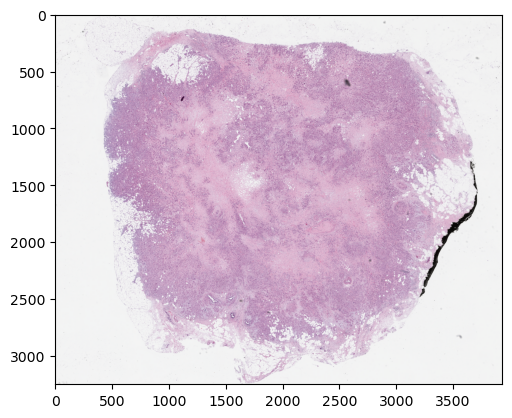

In [5]:
LEVEL = 2
height = int(slide_props[f'openslide.level[{LEVEL}].height'])
width = int(slide_props[f'openslide.level[{LEVEL}].width'])

slide_thumb = slide.get_thumbnail(size=(height, width))
slide_thumb_np = np.array(slide_thumb)
plt.imshow(slide_thumb_np) 

In [3]:
# Read in xml file
os.chdir(main_directory + '/data/raw/xml_labels')
xml_data_directory = os.getcwd()

xml_file = image_id + '.xml'

In [4]:
# Check working with correct svs corresponding to xml file
print(f'svs file name is {slide_props["aperio.Filename"]}')
print(f'xml file name is {xml_file}')
print(xml_file.rstrip('.xml') == slide_props['aperio.Filename'])

svs file name is TCGA-C8-A12Q-01Z-00-DX1
xml file name is TCGA-C8-A12Q-01Z-00-DX1.xml
True


In [5]:
points = []
features = []

# Get annotations from XML file
tree = ET.parse(xml_file)
root = tree.getroot()
for Annotation in root.findall("./Annotation"): # for all annotations
    # iterate on all regions
    for Region in Annotation.findall("./*/Region"):
        # extract region attributes
        regionID = Region.attrib['Id']; regionArea = Region.attrib['Area']
        # iterate all points in region
        for Vertex in Region.findall("./*/Vertex"):
            # get points
            x_point = float(np.int32(np.float64(Vertex.attrib['X'])))
            y_point = float(np.int32(np.float64(Vertex.attrib['Y'])))
            points.append([x_point, y_point])
        # features.append(Feature(geometry=Polygon([points]), properties={"name": xml_file, "region_id": regionID, "object_type": "annotation"}))

# feature_collection = FeatureCollection(features)

# Save as geojson file
# with open('shapes.geojson', 'w') as f:
#    dump(feature_collection, f)

In [6]:
[width0, height0] = slide.dimensions
print(width0, height0)

76160 62955


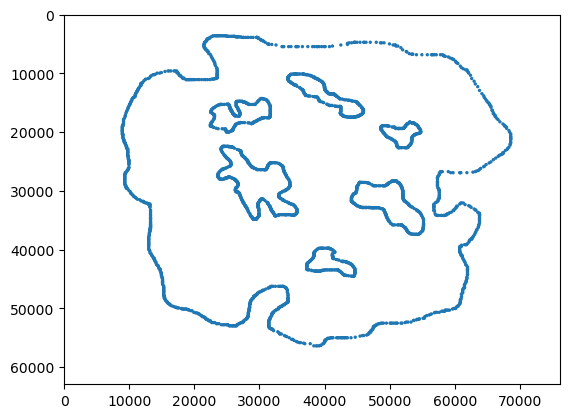

In [7]:
x_points = [points[i][0] for i in range(len(points))]
y_points = [points[i][1] for i in range(len(points))]
plt.scatter(x_points, y_points, [2]*len(x_points))
plt.xlim([0, width0]); plt.ylim([0, height0])
plt.gca().invert_yaxis()

In [8]:
# Get downsample factors
factors = slide.level_downsamples
print(f'Downsample factors: {factors}')

# Choose level to work with
LEVEL = 2
height = slide_props[f'openslide.level[{LEVEL}].height']
width = slide_props[f'openslide.level[{LEVEL}].width']
FACTOR = factors[LEVEL]
print(f"Downsampled image height: {height} and width: {width}")
print(f"Working with image downsampled by {FACTOR}")

Downsample factors: (1.0, 4.000095310712924, 16.001398068124047, 32.002796136248094)
Downsampled image height: 3934 and width: 4760
Working with image downsampled by 16.001398068124047


In [ ]:
# Downsample all annotation points
# (x, y)
downsample_points = []
for point in points:
    downsample_points.append([int(point[0]/FACTOR), int(point[1]/FACTOR)])

# Initialise downsampled binary image
binary_image = np.ones([int(height), int(width)])

for point in downsample_points:
    binary_image[point[1], point[0]] = 0

In [ ]:
x_points = [downsample_points[i][0] for i in range(len(downsample_points))]
y_points = [downsample_points[i][1] for i in range(len(downsample_points))]
print(np.max(x_points))
print(np.max(y_points))

In [ ]:
# duplicate coordinates?
print(len(list(set(map(tuple,downsample_points)))))

In [ ]:
print(len(downsample_points))
print(binary_image)
print(np.count_nonzero(binary_image == 0))

In [ ]:
# Visualise binary image
plt.figure(figsize=(8,8))
plt.imshow(binary_image, cmap="gray", vmin=0, vmax=1)    